# Installation

In [7]:
!pip install sofasonix
# Mount Google Drive!

# Import Libraries

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from SOFASonix import SOFAFile
import scipy
import scipy.io.wavfile as wav
from scipy import signal
from scipy.stats import norm

import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.insert(0,'/content/drive/My Drive/binaural_localization/LRP/') # needed to import innvestigator.py file
from innvestigator import InnvestigateModel

# Neural network class definition

In [9]:
class NN_3_layer(nn.Module):

    def __init__(self, input_size, out_size_1, out_size_2, out_size_3, out_size_pred):
        # call to the super class constructor
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=out_size_1)
        self.fc2 = nn.Linear(in_features=out_size_1, out_features=out_size_2)
        self.fc3 = nn.Linear(in_features=out_size_2, out_features=out_size_3)
        self.out = nn.Linear(in_features=out_size_3, out_features=out_size_pred)
        
    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden linear layer
        t = self.fc1(t)
        t = F.relu(t)

        # (3) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (4) hidden linear layer
        t = self.fc3(t)
        t = F.relu(t)

        # (5) output layer
        t = self.out(t)

        return t

# Evaluation class definition

In [10]:
class Evaluation():
  '''
    The class is used to load a model and its dataset and to apply error evaluation as well as layer-wise relevance propagation (LRP)
  '''
  def __init__(self, model_name, signal_name, front):
    '''
      Load the model and the dataset for evaluation
      INPUT:
        model_name:   string; name of the model saved as .pt
        signal_name:  string; selection of the accustic signal used for direction of arrival (DOA) estimation
                      two options implemented, i.e. 'noise' and 'speech' (addidional cases can be added easily)
        front:        binary; if True only front directions are considered, if False all directions in the database are used
    '''
    PATH = '/content/drive/My Drive/binaural_localization/models/'
    self.model = torch.load(PATH+model_name)
    #self.model = torch.load('/content/drive/My Drive/binaural_localization/models/model (100, 40, 10) front=True epoch=20 batch_size=142578 lr=0.001.pt')

    loadsofa = SOFAFile.load("/content/drive/My Drive/binaural_localization/HRIR_FULL2DEG.sofa")
    data = loadsofa.data_ir
    sr = int(loadsofa.Data_SamplingRate[0]) # sampling_rate in Hz
    direction = loadsofa.SourcePosition
    direction = direction[:,0:2]

    if front == True:
      # only the front -> no front back confusion
      # directions from the front have azimuth angels in the range [0...90] and [270...360]
      front_mask = np.logical_or(direction[:,0] < 90, direction[:,0] > 270)
      direction = direction[front_mask]
      data = data[front_mask]
      # 90 degree left, 0 degree front, -90 degree right (positive angles increase counter clockwise)
      func = np.vectorize(lambda d: d - 360 if d > 270 else d)
      direction[:,0] = func(direction[:,0])
    direction = direction*np.pi/180 # in rad

    if signal_name == 'noise':
      ## create noise signal##
      duration = 0.55 #seconds
      sample_n = int(duration*sr)
      noise = np.random.uniform(-1,1,sample_n)
      signal = noise

    if signal_name == 'speech':
      ## create speech signal
      load_speech = wav.read('/content/drive/My Drive/binaural_localization/hallo_speech.wav')
      speech = load_speech[1]
      sampling_rate = load_speech[0]
      if sampling_rate != sr:
        print('Warning: sampling_rate != sr')
      signal = speech

    def get_spec(time_signal):
      '''
        Calculate the short time Fourier transformation (STFT)
        INPUT:
          time_signal:  1D numpy array being the accoustic signal in time domain
        OUTPUT:
          spec.T:       STFT spectrogram transposed to have frequency bins on the x-axis
      '''
      win_length = int(sr*0.025) # 0.025s
      hop_t = 0.01 # in s
      nfft= win_length + 0 # zero padding
      f, t, spec = scipy.signal.spectrogram(time_signal, 
                               fs= sr,
                               window='hann', #'hann': cosine window; ('tukey', 0.25) creates a constant plateau in between
                               nperseg= win_length, 
                               noverlap= int(sr*(0.025-hop_t)), #10ms hop_length => 25ms-10ms overlap
                               nfft= nfft,
                               detrend= False, #if 'constant': for every time frame substract its mean;
                               return_onesided= True, # return a one-sided spectrum for real data
                               scaling= 'density', # units of V**2/Hz, here no influence, since mode = ‘complex’
                               axis= -1,
                               mode= 'complex' )
      f_mask = np.logical_and(f >= 20, f <= 20000)
      spec = spec[f_mask]
      return spec.T # dimension: n_time_frames x n_freq_samples => every time frame is a new data sample

    def get_direction_data(signal, i_d):
      '''
      Calculate interaural level difference (ILD) for the direction with index i_d
      INPUT:
        signal:           1D numpy array being the accoustic signal in time domain
        i_d:              index of the direction in the HRIR database 
      OUPUT:
        ILD:              2D numpy ndarray; ILD for the direction with index i_d
        target_direction: 2D numpy ndarray of dimension n_time_frames x 2; direction in database with index i_d
      '''
      hrir_l, hrir_r = data[i_d][0], data[i_d][1]
      spec_l = get_spec(np.convolve(signal, hrir_l, mode='valid')) 
      spec_r = get_spec(np.convolve(signal, hrir_r, mode='valid'))
      ILD = 20*np.log10(np.abs(spec_l)) - 20*np.log10(np.abs(spec_r))
      # duplicate the direction for every time_frame of the spectrogram, (NN will predict direction for every time_frame)
      target_direction = np.vstack([direction[i_d]]*np.shape(ILD)[0])
      # rows are ILD of one time_frame + direction for this time_frame
      return ILD, target_direction

    def get_all_directions(signal):
      '''
      Calculate interaural level difference (ILD) for the direction in data (which is set according to front = True/False)
      INPUT:
        signal:           1D numpy array being the accoustic signal in time domain
      OUPUT:
        features:         2D numpy ndarray; ILDs for all directions; every row is the Fourier transform of a time frame 
        targets:          2D numpy ndarray of dimension n_time_frames*n_directions x 2; direction of the ILD with the same row index
      '''
      test_feature, test_target = get_direction_data(signal, 0)
      n_directions = np.shape(direction)[0]
      n_t_frames = np.shape(test_feature)[0]
      features = np.zeros( (n_directions * n_t_frames, np.shape(test_feature)[1]) )
      targets = np.zeros( (n_directions * n_t_frames, 2) )
      for i_d in range(n_directions): 
        features[i_d*n_t_frames: (i_d+1)*n_t_frames], targets[i_d*n_t_frames: (i_d+1)*n_t_frames] =  get_direction_data(signal, i_d)
      features = torch.tensor(features).float() # the tensor has to be casted to float for the propagation process
      targets = torch.tensor(targets).float()
      return features, targets

    ## get data, feed model and save prediction
    self.features_tensor, self.targets_tensor = get_all_directions(signal) # create torch data
    self.features, self.targets = self.features_tensor.numpy(), self.targets_tensor.numpy() # numpy data
    self.targets_grad = self.targets*180/np.pi # in grad
    self.model.eval()
    with torch.no_grad():
      self.preds_tensor = self.model(self.features_tensor) # calculate predictions with the NN model
      self.preds = self.preds_tensor.numpy()
      self.preds_grad = self.preds*180/np.pi # in grad  
      self.az = self.targets_grad[:,0]
      self.el = self.targets_grad[:,1]
    # make some variables accessable for other methods
    self.direction = direction
    self.signal = signal
    self.data = data
    self.signal_name = signal_name

  ########### Error evaluation methods ###########
  def print_mse(self):
    '''
      Print the mean squared error (MSE) as it is used during training (containing azimuth and elevation)
    '''
    criterion = nn.MSELoss()
    loss_mse = criterion(self.preds_tensor, self.targets_tensor)
    print('MSE Loss in rad: ', np.round(loss_mse.item(), 2))
    print('MSE Loss in grad: ', np.round(loss_mse.item()*180/np.pi, 2))
    print('RMSE Loss in grad: ', np.round(np.sqrt(loss_mse.item())*180/np.pi, 2))

  def print_mean_az_el_dist(self):
    '''
      Print MSE for azimuth and elevation seperately
    '''
    az_dist = np.abs(self.preds_grad[:,0]-self.az)
    el_dist = np.abs(self.preds_grad[:,1]-self.el)
    print('mean_az_dist in grad', np.round(np.mean(az_dist).item(), 2))
    print('mean_el_dist in grad', np.round(np.mean(el_dist).item(), 2))


  def plot_az_el_hist_fit(self):
    '''
      Plot the (discrete) probability density function (PDF) of angle differences for azimuth and elevation as histogram with a normal distributino fit.
      The hight of each histogram bar is defined by the number of predictions which have a distance between predicted and true angle which falls into the corrosponding bin.
      Histogram bars are normalized so that surface area over all bars is one. Hence, the hight can be interpreted as probability.
    '''
    plt.style.use('ggplot')
    az_diff = self.preds_grad[:,0]-self.az
    el_diff = self.preds_grad[:,1]-self.el
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6.5,5))
    fig.patch.set_facecolor('white')
    fig.suptitle('Probability density function (PDF) of angle differences', fontsize=14)
    # Azimuth
    n,bins,patches=ax[0].hist(az_diff, density=True, bins=300, facecolor='gray')
    (mu,sigma) = norm.fit(az_diff) # Gaussian normal distribution fit
    r_mu, r_sigma = np.round(mu.item(),2), np.round(sigma.item(),2)
    print(f'Normal distribution fit for az_diff: mu={r_mu}, sigma={r_sigma}')
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    pdf = norm.pdf(x=bin_centers, loc=mu, scale=sigma) # probability density function
    ax[0].plot(bin_centers, pdf, label=f"normal distribution fit:\n$\sigma={r_sigma}$, $\mu={r_mu}$ ", color='black') #Plot PDF
    ax[0].legend()
    ax[0].set(title='Azimuth', xlabel='(predicted azimuth - true azimuth) in degree ', ylabel='Probability')
    fig.tight_layout()
    # Elevation
    n,bins,patches=ax[1].hist(el_diff, density=True, bins=300, facecolor='gray')
    mu,sigma = norm.fit(el_diff) # Gaussian normal distribution fit
    r_mu, r_sigma = np.round(mu.item(),2), np.round(sigma.item(),2)
    print(f'Normal distribution fit for el_diff: mu={r_mu}, sigma={r_sigma}')
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    pdf = norm.pdf(x=bin_centers, loc=mu, scale=sigma) # probability density function
    ax[1].plot(bin_centers, pdf, label=f"normal distribution fit:\n$\sigma={r_sigma}$, $\mu={r_mu}$ ", color='black') #Plot PDF
    ax[1].legend()
    ax[1].set(title='Elevation', xlabel='(predicted elevation - true elevation) in degree ', ylabel='Probability')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/PDF of angle difference for {signal_name} front.png')
    plt.style.use('default')

  def distance_with_angular_mean(self):
    '''
      Plot azimuth and elevation angle distance as heatmap over directions. Azimuth and elevation are circular quantities and the difference between 359° and 1° azimuth should be -2° and not 359°-1°=358°.
      Using the angle difference, 359°-1°=358° is projected on the unit circle and the angle of this projection is -2°. This es especially important when taking the absolute angle distance for full azimuth range.
      https://en.wikipedia.org/wiki/Mean_of_circular_quantities
    '''
    print('distance_with_angular_mean')
    az_ang_dist = np.abs(torch.atan2(torch.sin(self.preds_tensor[:,0] - self.targets_tensor[:,0]), torch.cos(self.preds_tensor[:,0] - self.targets_tensor[:,0]))*180/np.pi)
    el_ang_dist = np.abs(torch.atan2(torch.sin(self.preds_tensor[:,1] - self.targets_tensor[:,1]), torch.cos(self.preds_tensor[:,1] - self.targets_tensor[:,1]))*180/np.pi)
    print('az_ang_dist in grad: ', np.round(torch.mean(az_ang_dist).item(), 2))
    print('el_ang_dist in grad: ', np.round(torch.mean(el_ang_dist).item(), 2))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
    fig.patch.set_facecolor('white')
    # Azimuth
    map = ax[0].hexbin(self.az, self.el, C=az_ang_dist.numpy(), gridsize=60, cmap=matplotlib.cm.jet, bins=None)
    cb = plt.colorbar(map, ax=ax[0])
    cb.set_label('Azimuth distance in degree')
    ax[0].set(title = 'Azimuth distance over direction', xlabel='Azimuth in degree', ylabel='Elevation in degree')
    fig.tight_layout()
    # Elevation
    map = ax[1].hexbin(self.az, self.el, C=el_ang_dist.numpy(), gridsize=60, cmap=matplotlib.cm.jet, bins=None)
    cb = plt.colorbar(map, ax=ax[1])
    cb.set_label('Elevation distance in degree')
    ax[1].set(title = 'Elevation distance over direction', xlabel='Azimuth in degree', ylabel='Elevation in degree')
    fig.tight_layout()
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/az el dist for {signal_name} front.png')

  def get_i_d(self, az_wish, el_wish):
    '''
    Find the row index of the direction pair which is the closest do the desirec direction (az_wish, el_wish).
    '''
    m_altered = np.abs(self.direction[:,0]- az_wish) + np.abs(self.direction[:,1]- el_wish)
    m_min = np.amin(m_altered, axis=0)
    i_row = np.argwhere(m_altered == m_min)[0][0]
    return i_row

  def around_the_head_error(self, el_wish=0):
    '''
      Plot the angular distance of azimuth and elevation for a fixed elevation over azimuth.
      INPUT:
        el_wish:  Elevation at which anular distances are evaluted
    '''
    n_az = 400 # set emperically; there are repetitions, but not too many
    az = np.zeros(n_az)
    el = np.zeros(n_az)
    az_error = np.zeros(n_az)
    el_error = np.zeros(n_az)
    if front == True:
      az_range = np.linspace(-np.pi/2,np.pi/2, n_az)
    else:
      az_range = np.linspace(0,2*np.pi, n_az)
    for i, az_i in enumerate(az_range):
      i_d = self.get_i_d(az_wish = az_i, el_wish=el_wish)
      az_error[i] = np.abs(torch.atan2(torch.sin(self.preds_tensor[i_d,0] - self.targets_tensor[i_d,0]), torch.cos(self.preds_tensor[i_d,0] - self.targets_tensor[i_d,0])))
      el_error[i] = np.abs(torch.atan2(torch.sin(self.preds_tensor[i_d,1] - self.targets_tensor[i_d,1]), torch.cos(self.preds_tensor[i_d,1] - self.targets_tensor[i_d,1])))
      az[i] = self.direction[i_d, 0]
      el[i] = self.direction[i_d, 1]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2.5))
    fig.patch.set_facecolor('white')
    ax.plot(az*180/np.pi, az_error*180/np.pi, label='azimuth angle distance')
    ax.plot(az*180/np.pi, el_error*180/np.pi, label='elevation angle distance')
    ax.legend()
    ax.set(title = f'Azimuth and elevation distance over azimuth for {el_wish}° elevation', xlabel='Azimuth in degree', ylabel='Angle distance in degree')
    fig.tight_layout()
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/Spherical angle distance over azimuth for {el_wish} elevation for {signal_name} front.png')

  def eval(self):
    '''
      Apply a set of error evaluation methods at once.
    '''
    self.print_mse()
    self.print_mean_az_el_dist()
    self.plot_az_el_hist_fit()
    self.distance_with_angular_mean()
    self.around_the_head_error(el_wish=0)

  ########### Layer-wise relevance propagation (LRP) methods ###########

  def get_spec_full(self, convolved_signal):
    '''
    Calculate the short time Fourier transformation (STFT) and reurn also the frequency vector f and the time vector t
    INPUT:
      time_signal:  1D numpy array being the accoustic signal in time domain
    OUTPUT:
      complex_spec: 2D numpy array of dimension (len(f) x len(t)); STFT spectrogram 
      f:            1D array of frequency bins
      t:            1D array of time frame bins
    '''
    sr = 48000 # Hz
    win_length = int(sr*0.025) # 0.025s
    hop_length = 0.01 # in s
    nfft= win_length + 0 # zero padding
    f, t, complex_spec = scipy.signal.spectrogram(convolved_signal, 
                               fs= sr, 
                               window='hann', #'hann': cosine window; ('tukey', 0.25) creates a constant plateau in between
                               nperseg= win_length, 
                               noverlap= int(sr*(0.025-hop_length)), #10ms hop_length => 25ms-10ms overlap
                               nfft= nfft, 
                               detrend= False, #if 'constant': for every time frame substract its mean;
                               return_onesided= True, # return a one-sided spectrum for real data
                               scaling= 'density', # units of V**2/Hz, but should have no influence, since mode = ‘complex’
                               axis= -1, 
                               mode= 'complex' )
    f_mask = np.logical_and(f >= 20, f <= 20000)
    complex_spec = complex_spec[f_mask]
    f = f[f_mask]
    return f, t, complex_spec

  def get_inn_model(self, model):
    '''
      Helper method to create a innvestigation model according to the defined LRP settings. This model can be used to create relevance heatmaps for specific input vectors.
    '''
    inn_model = InnvestigateModel(model,  lrp_exponent=2,
                                          method="e-rule",
                                          beta=0) # Only relevant for method 'b-rule'
    return inn_model

  def relevance_heatmap_over_az(self, el_wish):
    '''
      Plot the ILD frequency bin relevance as heatmap over azimuth angles for a given elevation.
      INPUT:
        el_wish:  Elevation at which relevance is plotted over azimuth
    '''
    n_az = 400 # set emperically; there are repetitions, but not too many
    az = np.zeros(n_az)
    inn_model = self.get_inn_model(self.model)
    if front == True:
      az_range = np.linspace(-np.pi/2,np.pi/2, n_az)
    else:
      az_range = np.linspace(0,2*np.pi, n_az)
    for i, az_i in enumerate(az_range):
      i_d = self.get_i_d(az_wish=az_i, el_wish=el_wish)
      model_prediction, heatmap_i = inn_model.innvestigate(in_tensor=self.features_tensor[i_d])
      if i == 0:
        hrir_l = self.data[i_d][0]
        f_l, t_l, complex_spec_l = self.get_spec_full(np.convolve(self.signal, hrir_l, mode='valid'))
        f = f_l
        m = np.zeros((len(heatmap_i),n_az))
      m[:,i] = heatmap_i
      az[i] = self.direction[i_d, 0]
    relevance_heatmap = np.abs(m)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
    fig.patch.set_facecolor('white')
    spec = ax.pcolormesh(az*180/np.pi, f/1000, relevance_heatmap ) 
    cb = plt.colorbar(spec, ax=ax)
    cb.set_label('Relevance')
    ax.set(title = f'Relevance heatmap over azimuth with elevation {el_wish}°', xlabel='Azimuth in degree', ylabel='Frequency in kHz')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/LWRP over azimuth for {el_wish} elevation for {signal_name} front abs.png')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
    fig.patch.set_facecolor('white')
    spec = ax.pcolormesh(az*180/np.pi, f/1000, 10*np.log10(relevance_heatmap) ) 
    cb = plt.colorbar(spec, ax=ax)
    cb.set_label('Relevance in dB')
    ax.set(title = f'Relevance heatmap over azimuth with elevation {el_wish}°', xlabel='Azimuth in degree', ylabel='Frequency in kHz')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/LWRP over azimuth for {el_wish} elevation for {signal_name} front abs dB.png')


# Conduct Analysis of different networks and setups by creating 'Evaluation' instances

Setting dimension 'r' from parameter 'ReceiverPosition'
Setting dimension 'e' from parameter 'EmitterPosition'
Setting dimension 'm' from parameter 'Data.IR'
Setting dimension 'n' from parameter 'Data.IR'
Inserting foreign parameter: 'GLOBAL:Author'
Inserting foreign parameter: 'GLOBAL:ListenerDescription'
Inserting foreign parameter: 'GLOBAL:ReceiverDescription'
Inserting foreign parameter: 'GLOBAL:SourceDescription'
Inserting foreign parameter: 'GLOBAL:RoomDescription'
MSE Loss in rad:  0.31
MSE Loss in grad:  17.92
RMSE Loss in grad:  32.04
mean_az_dist in grad 17.44
mean_el_dist in grad 30.93
Normal distribution fit for az_diff: mu=-0.65, sigma=22.43
Normal distribution fit for el_diff: mu=-9.99, sigma=38.08
distance_with_angular_mean
az_ang_dist in grad:  17.44
el_ang_dist in grad:  30.93


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:347: RuntimeWarning: divide by zero encountered in log10


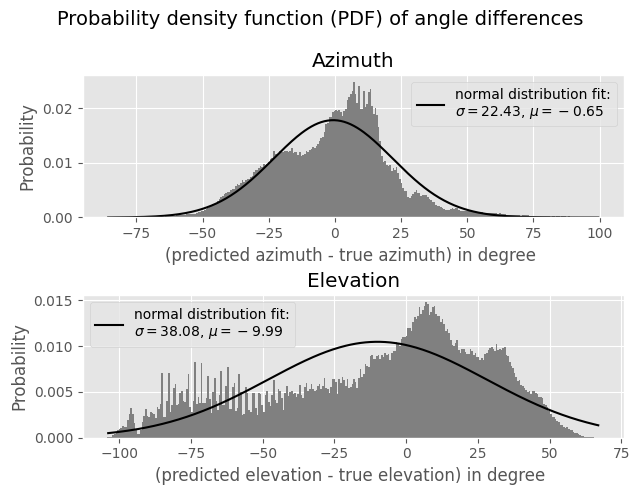

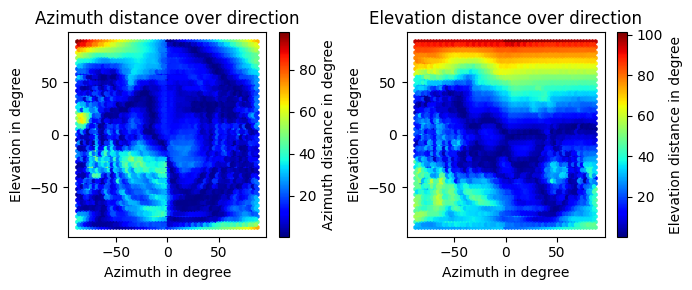

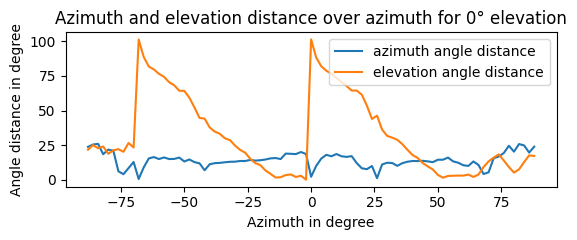

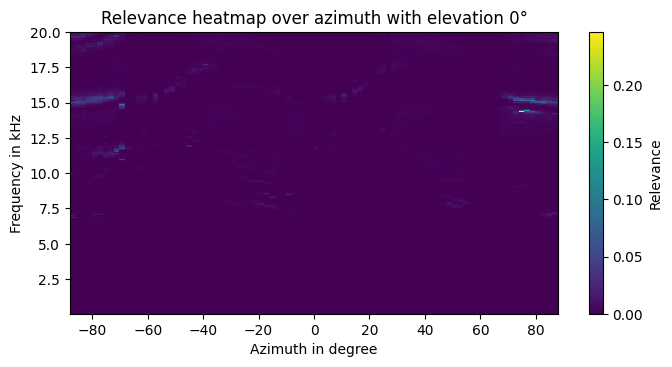

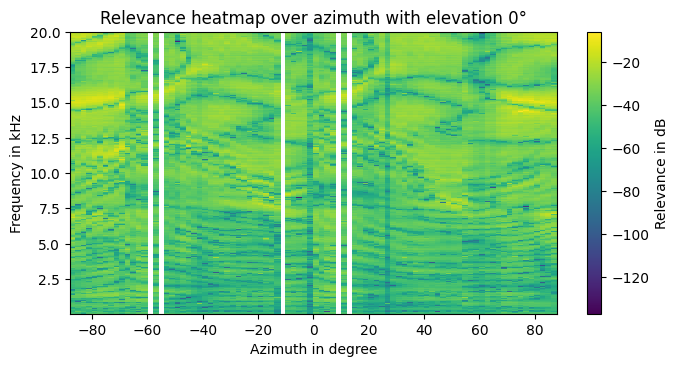

In [11]:
model_name = 'model (100, 40, 10) front=True epoch=20 batch_size=142578 lr=0.001.pt'
signal_name ='speech'
front = True
test = Evaluation(model_name, signal_name, front)
test.eval()
test.relevance_heatmap_over_az(el_wish=0)